# 数据加载

启动Hadoop

In [ ]:
start-dfs.sh
start-yarn.sh
jps

将arxiv-abstracts-all.txt和arxiv-titles-all.txt这两个文件从虚拟机中的本地路径（/home/bitnami/Desktop）存储到Hadoop的HDFS上

In [ ]:
cd /home/bitnami/Desktop

在HDFS上创建一个新目录来存储这些文件

In [ ]:
hadoop fs -mkdir /arxiv_data

从本地路径上传到HDFS上,/arxiv_data/是HDFS上的目标目录

In [ ]:
hadoop fs -put arxiv-abstracts-all.txt /arxiv_data/
hadoop fs -put arxiv-titles-all.txt /arxiv_data/

hadoop fs -ls /arxiv_data/

删除操作：
hadoop fs -rm /path/to/your/file
hadoop fs -rm -r /path/to/your/directory

# 数据预处理

### 基于pig的UDFs数据预处理

创建pig脚本 process_data.pig

In [ ]:
-- 定义UDF
DEFINE CleanText myudfs.CleanText();
DEFINE RemoveStopWords myudfs.StopWordsRemover();
DEFINE StemText myudfs.StemmerUDF();

-- 加载文件
abstracts = LOAD 'hdfs:/arxiv_data/arxiv-abstracts-all.txt' USING TextLoader() AS (abstract:chararray);
titles = LOAD 'hdfs:/arxiv_data/arxiv-titles-all.txt' USING TextLoader() AS (title:chararray);

-- 清洗文本
clean_abstracts = FOREACH abstracts GENERATE CleanText(abstract) AS cleaned_abstract;
clean_titles = FOREACH titles GENERATE CleanText(title) AS cleaned_title;

-- 进一步处理：去除停用词和词干化
-- 假设UDFs RemoveStopWords 和 StemText 已经定义好并注册
processed_abstracts = FOREACH clean_abstracts GENERATE StopWordsRemover(cleaned_abstract) AS processed_abstract;
processed_abstracts = FOREACH processed_abstracts GENERATE StemmerUDF(processed_abstract) AS stemmed_abstract;

processed_titles = FOREACH clean_titles GENERATE StopWordsRemover(cleaned_title) AS processed_title;
processed_titles = FOREACH processed_titles GENERATE StemmerUDF(processed_title) AS stemmed_title;

-- 合并标题和摘要
-- 假设每行在两个文件中是对应的，我们可以用生成的默认行号来合并它们
ranked_abstracts = RANK processed_abstracts;
ranked_titles = RANK processed_titles;

-- 使用默认的行号作为键来关联标题和摘要
joined_data = JOIN ranked_abstracts BY $0, ranked_titles BY $0;

-- 选择关联后的数据，只保留清洗后的标题和摘要
final_data = FOREACH joined_data GENERATE 
    ranked_titles::stemmed_title AS title,
    ranked_abstracts::stemmed_abstract AS abstract;

-- 存储最终结果为CSV格式
STORE final_data INTO 'hdfs:/arxiv_data/output/arxiv.csv' USING PigStorage(',');


创建UDF用于执行文本处理,去除停用词和词干化处理

下载snowball库，解压并添加进pig依赖

In [ ]:
tar -xvzf libstemmer_java-2.2.0.tar.gz

cd libstemmer_java-2.2.0/java
javac org/tartarus/snowball/*.java org/tartarus/snowball/ext/*.java


打包编译后的类文件为JAR，并添加到pig的lib目录下管理依赖

In [ ]:
jar cvf snowball-stemmer.jar org/tartarus/snowball/*.class org/tartarus/snowball/ext/*.class

sudo mv org/tartarus/snowball/snowball-stemmer.jar /usr/local/pig-0.14.0/lib/

jar tf /usr/local/pig-0.14.0/lib/snowball-stemmer.jar

StopWordsRemover.java

In [ ]:
package myudfs;

import org.apache.pig.EvalFunc;
import org.apache.pig.data.Tuple;
import org.tartarus.snowball.ext.porterStemmer;

import java.io.IOException;
import java.util.Arrays;
import java.util.HashSet;
import java.util.Set;

public class StopWordsRemover extends EvalFunc<String> {
    private static final Set<String> STOP_WORDS = new HashSet<String>(Arrays.asList(
        // 你需要添加停用词列表
        "a", "an", "the", "and", "or", "but", "is", "are", "of", "for", "on"
    ));

    public String exec(Tuple input) throws IOException {
        if (input == null || input.size() == 0) {
            return null;
        }
        try {
            String str = (String)input.get(0);
            String[] words = str.split("\\s+");
            StringBuilder sb = new StringBuilder();
            for (String word : words) {
                if (!STOP_WORDS.contains(word.toLowerCase())) {
                    sb.append(word).append(' ');
                }
            }
            return sb.toString().trim();
        } catch(Exception e) {
            throw new IOException("Caught exception processing input row ", e);
        }
    }
}

StemmerUDF.java

In [ ]:
package myudfs;

import org.apache.pig.EvalFunc;
import org.apache.pig.data.Tuple;
import org.tartarus.snowball.ext.porterStemmer;

import java.io.IOException;
import java.util.Arrays;
import java.util.HashSet;
import java.util.Set;



public class StemmerUDF extends EvalFunc<String> {
    public String exec(Tuple input) throws IOException {
        if (input == null || input.size() == 0) {
            return null;
        }
        try {
            String field = (String)input.get(0);
            porterStemmer stemmer = new porterStemmer();
            stemmer.setCurrent(field);
            stemmer.stem();
            return stemmer.getCurrent();
        } catch(Exception e) {
            throw new IOException("Caught exception processing input row ", e);
        }
    }
}

CleanText.java

In [ ]:
package myudfs;

import org.apache.pig.EvalFunc;
import org.apache.pig.data.Tuple;
import java.io.IOException;

public class CleanText extends EvalFunc<String> {
    public String exec(Tuple input) throws IOException {
        if (input == null || input.size() == 0)
            return null;
        try {
            String str = (String)input.get(0);
            // 去除特殊字符和标点符号，转换为小写
            str = str.replaceAll("[^a-zA-Z0-9\\s]", "").toLowerCase();
            return str;
        } catch(Exception e) {
            throw new IOException("Caught exception processing input row ", e);
        }
    }
}

使用java编译UDF类：
打开命令行终端，导航到包含Java文件的目录。使用javac编译器来编译这些文件。
生成的myudf.jar添加到pig的依赖中管理

In [ ]:
mkdir Myudfs/compiled
javac -d Myudfs/compiled -cp "/usr/local/pig-0.14.0/pig-0.14.0-core-h2.jar:/usr/local/pig-0.14.0/lib/snowball-stemmer.jar:/usr/local/hadoop-2.6.0/share/hadoop/common/*:/usr/local/hadoop-2.6.0/share/hadoop/hdfs/*" Myudfs/*.java
jar cvf Myudfs.jar -C Myudfs/compiled Myudfs

jar tf Myudfs.jar

sudo mv Myudfs.jar /usr/local/pig-0.14.0/lib/

pig process_data.pig

In [ ]:
hadoop fs -get hdfs:/arxiv_data/output/cleaned_arxiv.csv /home/bitnami/Desktop/


### 基于spark的数据预处理

安装spark 3.5

https://dlcdn.apache.org/spark/spark-3.5.0/

In [ ]:
sudo apt-get update
sudo apt-get install gedit

In [ ]:
cd ~/Desktop
tar -xvzf spark-3.5.0-bin-hadoop3.tgz

sudo mv ~/Desktop/spark-3.5.0-bin-hadoop3  /usr/local/spark-3.5.0

gedit ~/.bashrc

export SPARK_HOME=/usr/local/spark-3.5.0
export PATH=$SPARK_HOME/bin:$SPARK_HOME/sbin:$PATH

source ~/.bashrc
重启虚拟机

数据清洗：大小写转换，去除特殊字符和标点符号

DataCleaning.scala

In [ ]:
import org.apache.spark.sql.SparkSession

val spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

val abstracts = spark.read.textFile("hdfs:/arxiv_data/arxiv-abstracts-all.txt")
val titles = spark.read.textFile("hdfs:/arxiv_data/arxiv-titles-all.txt")

def cleanData(text: String): String = {
    text.toLowerCase().replaceAll("[^a-zA-Z0-9\\s]", "")
}

val cleanedAbstracts = abstracts.map(cleanData)
val cleanedTitles = titles.map(cleanData)

// 示例：将清洗后的数据存储到HDFS
cleanedAbstracts.write.text("hdfs:/arxiv_data/cleaned_abstracts.txt")
cleanedTitles.write.text("hdfs:/arxiv_data/cleaned_titles.txt")

spark.stop()


In [ ]:
spark-shell -i DataCleaning.scala

hadoop fs -get hdfs:/arxiv_data/cleaned_abstracts.txt ~/Desktop
hadoop fs -get hdfs:/arxiv_data/cleaned_titles.txt ~/Desktop


分词，去除停用词

RemoveStopWords.scala

In [ ]:
import org.apache.spark.sql.SparkSession
import org.apache.spark.ml.feature.StopWordsRemover
import org.apache.spark.sql.functions._

val spark = SparkSession.builder.appName("RemoveStopWords").getOrCreate()

val cleanedAbstracts = spark.read.text("hdfs:/arxiv_data/cleaned_abstracts.txt")
val cleanedTitles = spark.read.text("hdfs:/arxiv_data/cleaned_titles.txt")

val remover = new StopWordsRemover()
    .setInputCol("words")
    .setOutputCol("filtered")

val tokenizer = udf { text: String => text.split(" ") }

val abstractsWords = cleanedAbstracts.withColumn("words", tokenizer(col("value")))
val titlesWords = cleanedTitles.withColumn("words", tokenizer(col("value")))

val filteredAbstracts = remover.transform(abstractsWords)
val filteredTitles = remover.transform(titlesWords)

val finalAbstracts = filteredAbstracts.select(concat_ws(" ", col("filtered")).alias("abstract"))
val finalTitles = filteredTitles.select(concat_ws(" ", col("filtered")).alias("title"))

finalAbstracts.write.text("hdfs:/arxiv_data/removed_abstracts.txt")
finalTitles.write.text("hdfs:/arxiv_data/removed_titles.txt")

spark.stop()

In [ ]:
spark-shell -i RemoveStopWords.scala

词干化


安装spark nlp库
https://sparknlp.org/docs/en/install

确保使用 --packages 参数启动 spark-shell：
每次启动 spark-shell 时，使用包含 Spark NLP 的 --packages 参数，即使库已经下载到了本地。

In [ ]:
spark-shell --packages com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4

TextStemming.scala

In [ ]:
import org.apache.spark.sql.SparkSession
import com.johnsnowlabs.nlp.DocumentAssembler
import com.johnsnowlabs.nlp.annotator.{Tokenizer, Stemmer}
import com.johnsnowlabs.nlp.Finisher
import org.apache.spark.ml.Pipeline
import org.apache.spark.sql.functions.concat_ws

val spark = SparkSession.builder.appName("TextProcessing").getOrCreate()
import spark.implicits._

// Spark NLP pipeline components
val documentAssembler = new DocumentAssembler().setInputCol("text").setOutputCol("document")
val tokenizer = new Tokenizer().setInputCols(Array("document")).setOutputCol("token")
val stemmer = new Stemmer().setInputCols(Array("token")).setOutputCol("stem")
val finisher = new Finisher().setInputCols(Array("stem"))

val pipeline = new Pipeline().setStages(Array(documentAssembler, tokenizer, stemmer, finisher))

// Load data
val cleanedAbstracts = spark.read.text("hdfs:/arxiv_data/removed_abstracts.txt").toDF("text")
val cleanedTitles = spark.read.text("hdfs:/arxiv_data/removed_titles.txt").toDF("text")

// Process data
val processedAbstracts = pipeline.fit(cleanedAbstracts).transform(cleanedAbstracts)
val processedTitles = pipeline.fit(cleanedTitles).transform(cleanedTitles)

// Save processed data separately
processedAbstracts.select(concat_ws(" ", $"finished_stem").alias("abstract_text"))
  .write.text("hdfs:/arxiv_data/processed_abstracts.txt")

processedTitles.select(concat_ws(" ", $"finished_stem").alias("title_text"))
  .write.text("hdfs:/arxiv_data/processed_titles.txt")

spark.stop()


In [ ]:
spark-shell --packages com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4

:load TextStemming.scala


TextToCsv.scala

In [ ]:
import org.apache.spark.sql.SparkSession
import org.apache.spark.sql.functions.monotonically_increasing_id

val spark = SparkSession.builder.appName("CombineTextToCSV").getOrCreate()

// 读取数据
val abstractsDF = spark.read.text("hdfs:/arxiv_data/processed_abstracts.txt").withColumnRenamed("value", "abstract")
val titlesDF = spark.read.text("hdfs:/arxiv_data/processed_titles.txt").withColumnRenamed("value", "title")

// 添加索引
val abstractsWithIndex = abstractsDF.withColumn("row_id", monotonically_increasing_id())
val titlesWithIndex = titlesDF.withColumn("row_id", monotonically_increasing_id())

// 合并DataFrame
val combinedDF = titlesWithIndex.join(abstractsWithIndex, "row_id").select("title", "abstract")

// 保存为CSV
combinedDF.write.option("header", "true").csv("hdfs:/arxiv_data/output_combined.csv")

spark.stop()


In [ ]:
spark-shell -i TextToCsv.scala

hadoop fs -ls /arxiv_data/
hadoop fs -get hdfs:/arxiv_data/output_combined.csv ~/Desktop

tar -czvf output_combined.tar.gz -C /home/bitnami/Desktop output_combined.csv

Combine.py

In [2]:
# -*- coding: utf-8 -*-
import os
import pandas as pd

# 文件夹路径
folder_path = 'D:\\BD_project\\output_combined.csv'
files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# 合并所有CSV文件
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

# 保存为单个CSV文件
output_file = 'D:\\BD_project\\combined_output.csv'  
df.to_csv(output_file, index=False)

## 模型训练部分

### TF-IDF & K-means

In [ ]:
hadoop fs -put DataForTfIdf.csv /arxiv_data/

使用Spark的 HashingTF 和 IDF 方法时，生成的词汇表是隐式的，因为 HashingTF 使用哈希技巧将词映射到索引。这意味着不会有一个显式的词汇表列表。相反，词被哈希到一个固定大小的空间，通常会有一些不同的词映射到同一个索引。

由于这种方法不存储整个词汇表，所以无法直接获取词汇表中的词。这种方法的优点是它可以有效地处理大规模词汇表，但缺点是它不提供反向映射来确定特定索引对应的原始词。

如果你需要一个可逆的、显式的词汇表，可能需要使用不同的方法，例如 CountVectorizer，它会构建一个完整的词汇表，但可能不适用于非常大的词汇集。

Clustering.scala

In [ ]:
import org.apache.spark.ml.feature.{HashingTF, IDF, Tokenizer}
import org.apache.spark.ml.clustering.KMeans
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.sql.{SparkSession, Row}

val spark = SparkSession.builder.appName("TFIDFClustering").getOrCreate()

// 读取HDFS上的文本文件
val data = spark.read.text("hdfs:/arxiv_data/ProcessedAbstracts.txt").toDF("text")

// Tokenizer用于将文本列分解成单词列表
val tokenizer = new Tokenizer().setInputCol("text").setOutputCol("words")
val wordsData = tokenizer.transform(data)

// 使用HashingTF将单词转换为原始特征向量
val hashingTF = new HashingTF().setInputCol("words").setOutputCol("rawFeatures").setNumFeatures(100000)
val featurizedData = hashingTF.transform(wordsData)

// 使用IDF转换TF特征
val idf = new IDF().setInputCol("rawFeatures").setOutputCol("features")
val idfModel = idf.fit(featurizedData)
val tfidfData = idfModel.transform(featurizedData)

// 将TF-IDF特征转换为稠密向量
val denseVectorData = tfidfData.select("features").rdd.map {
  case Row(features: Vector) => (features.toDense, features)
}.toDF("denseFeatures", "features")

输出tf-idf会导致内存爆炸，这段代码存在问题

In [ ]:
import org.apache.spark.sql.functions._
// denseVectorData 是DataFrame，包含了一个名为 'denseFeatures' 的列
// 将结构化的特征转换为字符串
val stringData = denseVectorData.withColumn("denseFeaturesString", col("denseFeatures").cast("string"))

// 保存为文本文件
stringData.select("denseFeaturesString").write.text("hdfs:/arxiv_data/TF_IDF_Result.txt")


In [ ]:

// 设置聚类的数量
val k = 8

// 创建K-Means实例并设置参数
val kmeans = new KMeans().setK(k).setSeed(1L)

// 训练模型
val model = kmeans.fit(denseVectorData)

// 获取数据的聚类分配
val predictions = model.transform(denseVectorData)

import org.apache.spark.sql.functions.col

// predictions 是 DataFrame，包含了一个名为 'prediction' 的列
// 将整数类型的 'prediction' 列转换为字符串
val stringPredictions = predictions.withColumn("predictionString", col("prediction").cast("string"))

// 保存为文本文件
stringPredictions.select("predictionString").write.text("hdfs:/arxiv_data/Kmeans_Result100000.txt")


spark.stop()


In [ ]:
spark-shell -i Clustering.scala

hadoop fs -ls /arxiv_data/

In [ ]:
hadoop fs -get /arxiv_data/Kmeans_Result100000.txt ~/Desktop
tar -czvf Kmeans_Result100000.tar.gz -C /home/bitnami/Desktop Kmeans_Result100000.txt

这是用于合并txt文件的函数，修改路径完成你的合并

In [2]:
import os

folder_path = 'D:\\BD_project\\cleaned_abstracts.txt'
output_file = 'D:\\BD_project\\CleanedAbstracts.txt'

with open(output_file, 'w') as outfile:
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as infile:
                for line in infile:
                    outfile.write(line)


重新部署环境后的代码

在processed_abstracts.tar.gz基础上工作

In [ ]:
tar -xvzf processed_abstracts.tar.gz

hadoop fs -mkdir /arxiv_data
hadoop fs -put ProcessedAbstracts.txt /arxiv_data/

永久删除
hdfs dfs -rm -r -skipTrash /arxiv_data/TF_IDF_Result.txt


In [ ]:
一、清理目录
1、执行sudo -u hdfs hadoop fs -du -h /
查询hdfs中各目录的占用的空间，进入占用最多的目录中（/tmp目录等）
2、找到目录/tmp/repay_prpjpolicypayment占用了大量空间
3、执行hdfs dfs -rm -r /tmp/repay_prpjpolicypayment删除此目录下的文件夹
4、删除的文件会被保存到/user/hdfs/.Trash，清空回收站即可

二、清空回收站
1.由于HDFS有回收站，删除文件会先放到回收站里边，如果着急释放空间，需要清理HDFS回收站
2、在删除HDFS文件时，可以使用命令：
hdfs dfs -rm -skipTrash /tmp/repay_prpjpolicypayment，文件就直接被删除，不会进入回收站（永久删除，无法恢复数据）
3、清空回收站命令：
hdfs dfs -expunge （回收站不会立即被清理，而是先Created trash checkpoint: /user/hdfs/.Trash/230309135102。显示的是一分钟后清除。）


## 数据分析可视化部分

总共数据条数 1578655

对于你的TF-IDF数据，如果维度非常高，可以首先尝试使用t-SNE或UMAP进行降维，然后用散点图来可视化二维数据。这样做通常可以帮助你理解数据的整体结构，看到数据点是否自然聚集成群，或者发现潜在的异常值。

完成聚类标签和仅完成数据清洗后的数据集的合并（去除大小写和标点）

In [ ]:
tar -czvf cleaned_abstracts.tar.gz -C /home/bitnami/Desktop cleaned_abstracts.txt

把CleanedAbstracts.txt和KmeansResult10W.txt合并成一个csv文件labeled_abstracts.csv

In [3]:
import pandas as pd

def merge_files(abstracts_file, kmeans_result_file, output_file):
    # 读取文件
    with open(abstracts_file, 'r', encoding='utf-8') as file:
        abstracts = file.readlines()

    with open(kmeans_result_file, 'r', encoding='utf-8') as file:
        labels = file.readlines()

    # 确保两个文件行数相等
    if len(abstracts) != len(labels):
        raise ValueError("Files do not have the same number of lines")

    # 去除换行符
    abstracts = [abstract.strip() for abstract in abstracts]
    labels = [label.strip() for label in labels]

    # 创建DataFrame
    df = pd.DataFrame({'Abstract': abstracts, 'Label': labels})

    # 保存为CSV文件
    df.to_csv(output_file, index=False, encoding='utf-8')

# 文件路径
abstracts_file = 'CleanedAbstracts.txt'
kmeans_result_file = 'KmeansResult10W.txt'
output_file = 'labeled_abstracts.csv'

# 执行合并
merge_files(abstracts_file, kmeans_result_file, output_file)


按照标签把摘要分别存入不同文件中

In [9]:
import pandas as pd

def split_and_count_by_label(input_file):
    # 读取CSV文件
    df = pd.read_csv(input_file)

    # 创建一个字典来存储每个标签的计数
    label_counts = {}

    # 对每个标签进行分组
    for label in df['Label'].unique():
        # 筛选出当前标签的所有摘要
        df_label = df[df['Label'] == label]

        # 计数并存储每个标签的文章数量
        label_counts[label] = df_label.shape[0]

        # 保存到单独的文件
        output_file = f'ClassifiedAbstracts\\abstracts_label_{label}.txt'
        df_label['Abstract'].to_csv(output_file, index=False, header=False, encoding='utf-8')

    # 打印每个标签的文章数量
    for label, count in label_counts.items():
        print(f"Label {label}: {count} articles")

# 输入文件路径
input_file = 'labeled_abstracts.csv'

# 执行函数
split_and_count_by_label(input_file)


Label 2: 117717 articles
Label 0: 760254 articles
Label 1: 206169 articles
Label 3: 207263 articles
Label 4: 245469 articles
Label 7: 19446 articles
Label 5: 19156 articles
Label 6: 3181 articles


- label 0 - 760254
- label 1 - 206169
- label 2 - 117717
- label 3 - 207263
- label 4 - 245496
- label 5 - 19156
- label 6 - 3181
- label 7 - 19446

词云生成

C:\Users\Speranza\AppData\Local\Temp\ipykernel_20180\682652257.py:6: DtypeWarning: Columns (2,7,8,12,13,14,15,16,17,18,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ClusterResult\\FinalProcessedData.csv', header=None)


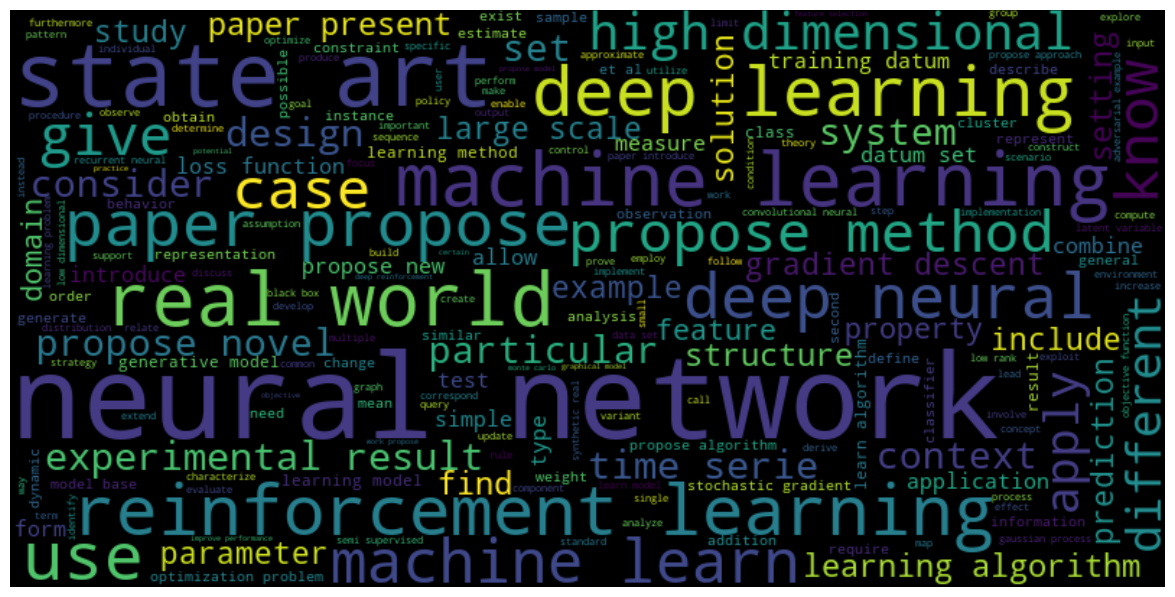

In [15]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('ClusterResult\\FinalProcessedData.csv', header=None)  

# 将所有摘要合并为一个长字符串
all_abstracts = ' '.join(df[19])

# 创建词云对象
wordcloud = WordCloud(width=800, height=400).generate(all_abstracts)

# 显示词云
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# 保存词云图片
wordcloud.to_file('wordcloud_CS_raw.png')


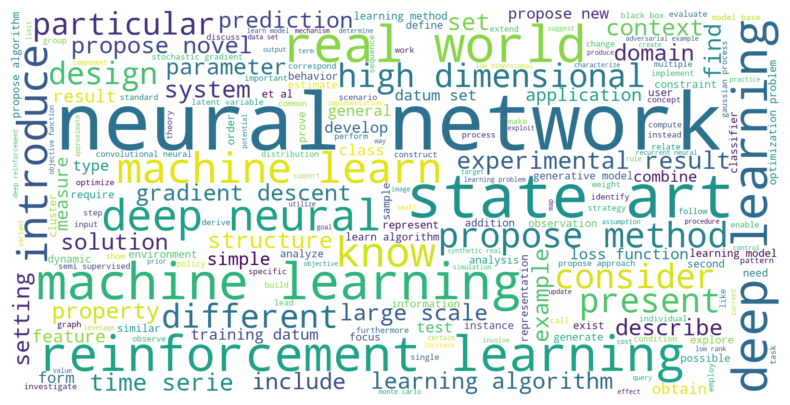

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image

# 添加自定义停用词
custom_stopwords = set([
    # 根据观察到的词云添加您认为不重要的词
    'paper', 'use','apply','case','give','allow','konw','study'
])

# 生成新的词云
wordcloud = WordCloud(
    width=1600,
    height=800,
    stopwords=custom_stopwords,  # 使用自定义停用词
    background_color='white'
).generate(all_abstracts)

# 显示新的词云
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud.to_file('wordcloud_CS_final.png')

In [4]:
!pip install WordCloud2

Could not fetch URL https://pypi.org/simple/wordcloud2/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/wordcloud2/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1129)'))) - skipping


ERROR: Could not find a version that satisfies the requirement WordCloud2 (from versions: none)
ERROR: No matching distribution found for WordCloud2

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('ClusterResult\\FinalProcessedData.csv', header=None)  

# 将所有摘要合并为一个长字符串
all_abstracts = ' '.join(df[19])

# 创建词云对象
wordcloud = WordCloud(width=800, height=400).generate(all_abstracts)

# 加载CS形状的图片作为mask
cs_mask = np.array(Image.open('CS_shape.png'))  # 确保替换为您的CS形状图片路径

# 添加自定义停用词
custom_stopwords = set([
    # 根据观察到的词云添加您认为不重要的词
    'paper', 'use', 'apply', 'case', 'give', 'allow', 'konw', 'study'
])

# 生成新的词云
wordcloud = WordCloud(
    width=1600,
    height=800,
    mask=cs_mask,  # 使用CS形状的mask
    stopwords=custom_stopwords,  # 使用自定义停用词
    background_color='white',
    contour_width=0,  # mask的轮廓宽度
    scale = 5,
    font_path="SimHei.ttf"
).generate(all_abstracts)

# 显示新的词云
plt.figure(figsize=(100, 100))  # 增加显示图像的尺寸
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# 将生成的词云保存为文件
wordcloud.to_file('wordcloud_CS_final4.png')


ImportError: cannot import name 'Wordcloud' from 'wordcloud' (c:\Users\Speranza\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\__init__.py)

In [3]:
from collections import Counter
import re

# 示例文本，请用您实际的文本字符串替换这里的内容。
text = all_abstracts

# 去除不需要的字符并分割文本为单词
words = re.findall(r'\w+', text.lower())

# 计算单词频率
word_counts = Counter(words)

# 如果需要，过滤掉常见的停用词（使用您的停用词列表）
stopwords = set([])

filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stopwords}

# 打印出单词频率
for word, count in filtered_word_counts.items():
    print(f"{word}: {count}")


order: 4932
defin: 3900
process: 2777
restrosynthesi: 1
new: 4241
organ: 124
molecul: 118
often: 569
necessari: 793
abl: 536
draw: 100
inspir: 237
similar: 1551
target: 464
on: 6535
know: 190
comput: 5816
oftent: 1
us: 10124
approach: 3023
solv: 2153
maximum: 4297
common: 844
edg: 14567
subgraph: 4515
mce: 9
problem: 16039
molecular: 172
graph: 95434
limit: 1755
time: 8997
pertin: 10
measur: 1960
paper: 9067
analys: 252
represent: 2254
algorithm: 14735
compar: 1288
purpos: 207
model: 7981
structur: 5823
smaller: 495
repres: 1706
interconnexion: 1
elementari: 234
cycl: 3863
provid: 4145
effici: 2402
obtain: 4704
evalu: 988
select: 706
set: 13794
known: 4084
precis: 802
three: 1630
transit: 1284
permut: 717
group: 4921
degre: 6334
6: 487
admit: 1510
invari: 1090
partit: 2643
part: 1107
size: 4507
2: 3332
kernel: 1046
action: 610
4: 1325
call: 3729
a46: 2
s46d: 2
s46c: 2
lin: 37
construct: 4201
infinit: 1963
famili: 2937
finit: 4059
connect: 8097
6valent: 7
gammannin: 1
mathbbn: 135
arctr

### 维度散点图

In [ ]:
hadoop fs -put ProcessedAbstracts.csv /arxiv_data/

PCA_reduce.scala

In [ ]:
import org.apache.spark.ml.feature.{HashingTF, IDF, Tokenizer}
import org.apache.spark.ml.clustering.KMeans
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.sql.{Row, SparkSession}
import org.apache.spark.sql.functions._

import org.apache.spark.ml.feature.PCA
import org.apache.spark.ml.linalg.Vector

val spark = SparkSession.builder.appName("TFIDFClustering").getOrCreate()

// Read the CSV file

val data = spark.read.option("header", "false").csv("hdfs:/arxiv_data/ProcessedAbstracts.csv")

// Assuming the column name in the CSV is "_c0" (default column name for CSV without header)

val textColumn = "_c0"
// Tokenize the text column

val tokenizer = new Tokenizer().setInputCol(textColumn).setOutputCol("words")
val wordsData = tokenizer.transform(data)

// Apply TF (term frequency) on the tokenized words
val hashingTF = new HashingTF().setInputCol("words").setOutputCol("rawFeatures").setNumFeatures(10000)
val featurizedData = hashingTF.transform(wordsData)

// Apply IDF (inverse document frequency) on the TF features
val idf = new IDF().setInputCol("rawFeatures").setOutputCol("features")
val idfModel = idf.fit(featurizedData)
val tfidfData = idfModel.transform(featurizedData)

// Save the TF-IDF vectors to a file
// val outputData = tfidfData.select("features").rdd.map { case Row(features) => features }
// outputData.saveAsTextFile("hdfs:/arxiv_data/jieguo")

// Convert the TF-IDF features to dense vectors

val denseVectorData = tfidfData.select("features").rdd.map {
  case Row(features: Vector) => (features.toDense, features)
}.toDF("denseFeatures", "features")

// Set the number of clusters
val k = 8

// Create a K-means instance
val kmeans = new KMeans().setK(k).setSeed(1L)

// Fit the model to the data
val model = kmeans.fit(denseVectorData)

// Get the cluster assignments for the data
val predictions = model.transform(denseVectorData)
val wordsDataWithId = wordsData.withColumn("id", monotonicallyIncreasingId())
val predictionsWithId = predictions.withColumn("id", monotonicallyIncreasingId())
val finalPredictions = wordsDataWithId.join(predictionsWithId, Seq("id")).select(textColumn, "prediction")

// Join the original data with the predictions
val finalPredictions = wordsData.zip(predictions).map {case (wordsRow, predictionsRow) =>(wordsRow.getAsString, predictionsRow.getAsInt)}.toDF(textColumn, "prediction")
//这一步有报错

// Show the cluster assignments
finalPredictions.show()

// Save the cluster assignments to a file
finalPredictions.select(textColumn, "prediction").write.csv("hdfs:/arxiv_data/finalPredictions.csv")

// 使用PCA降维到2维
val pca = new PCA()
  .setInputCol("denseFeatures")
  .setOutputCol("pcaFeatures")
  .setK(2)
  .fit(denseVectorData)

val pcaResult = pca.transform(denseVectorData)

// 将PCA结果与聚类标签合并
val joinedData = pcaResult.join(predictions, "denseFeatures")
  .select(col("pcaFeatures"), col("prediction"))

// 将结果转换为适合导出的格式
val resultForExport = joinedData.rdd.map(row => {
  val pcaFeatures = row.getAs[Vector]("pcaFeatures")
  val cluster = row.getAs[Int]("prediction")
  (pcaFeatures(0), pcaFeatures(1), cluster)
}).toDF("pcaFeature1", "pcaFeature2", "cluster")

// 导出数据
resultForExport.write.format("csv").save("hdfs:/arxiv_data/pca_cluster_result.csv")
spark.stop()

知识图谱

In [ ]:
import csv
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# 加载预训练的英文模型
nlp = spacy.load('en_core_web_sm')

# 读取CSV文件
abstracts = []
with open('cs-abstracts-sample.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        abstracts.extend(row)

# 提取实体
all_entities = []
for abstract in abstracts:
    doc = nlp(abstract)
    entities = [ent.text for ent in doc.ents if ent.label_ in ['PRODUCT', 'CONCEPT','ORG','LANGUAGE','SOFTWARE','TECHNOLOGY', 'WORK_OF_ART']]  # 仅提取人名、组织机构和地名实体
    all_entities.extend(entities)

# 统计实体出现次数
entity_counts = Counter(all_entities)

# 选择前70个频率最高的实体
top_50_entities = [entity for entity, count in entity_counts.most_common(70)]

# 创建知识图谱
graph = nx.Graph()

# 构建边
for abstract in abstracts:
    doc = nlp(abstract)
    entities = [ent.text for ent in doc.ents if ent.text in top_50_entities]
    for i, entity1 in enumerate(entities):
        for j, entity2 in enumerate(entities):
            if i != j:
                graph.add_edge(entity1, entity2)

In [ ]:
# 可视化图谱
plt.figure(figsize=(30, 24))
cmap = plt.cm.get_cmap('Reds')  # 选择颜色映射，这里使用蓝色调色板

# 生成颜色列表
colors = [cmap(i / 70) for i in range(70)] 
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_color=colors, node_size=1700)
nx.draw_networkx_edges(graph, pos, edge_color='lightblue')
nx.draw_networkx_labels(graph, pos, font_size=15, font_family='sans-serif')
plt.axis('off')

# 保存图谱为PNG图像
plt.savefig('knowledge_graph1.png', dpi=300)

### 使用R语言实现词云

安装词云相关包文件

In [ ]:
install.packages("wordcloud")
install.packages("tm")
library(wordcloud)
library(tm)


In [ ]:
library(wordcloud)
library(tm)
library(png)

# 读取数据
data <- read.csv('D:\\BD_project\\ClusterResult\\FinalProcessedData.csv', header=FALSE)  # 确保替换为您的CSV文件路径

# 将所有摘要合并为一个长字符串
all_abstracts <- paste(data[,20], collapse=" ")  # 确保替换为正确的列号

# 加载CS形状的图片作为mask
cs_mask <- readPNG('D:\\BD_project\\CS_shape.png')  # 确保替换为您的CS形状图片路径
cs_mask <- array(data=cs_mask, dim=c(dim(cs_mask)[1], dim(cs_mask)[2], 1))  # 将图片转换为灰度

# 创建文本文档对象
docs <- Corpus(VectorSource(all_abstracts))

# 文本预处理
docs <- tm_map(docs, content_transformer(tolower))
docs <- tm_map(docs, removePunctuation)
docs <- tm_map(docs, removeWords, c(stopwords("en"), 
                                    'paper', 'use', 'apply', 'case', 'give', 'allow', 'konw', 'study'))  # 添加自定义停用词

# 生成词云
wordcloud(words = as.vector(unlist(sapply(docs, `[`, "content"))), 
          scale=c(5,2),
          max.words=200,
          random.order=FALSE,
          rot.per=0.35,
          colors=brewer.pal(8, "Dark2"),
          mask=cs_mask)

# 如果您希望保存生成的词云，可以使用png()函数
png('wordcloud_CS_finalR.png', width=1600, height=800)
wordcloud(words = as.vector(unlist(sapply(docs, `[`, "content"))), 
          scale=c(5,2),
          max.words=200,
          random.order=FALSE,
          rot.per=0.35,
          colors=brewer.pal(8, "Dark2"),
          mask=cs_mask)
dev.off()



In [ ]:
# 安装和加载包
install.packages("wordcloud2")
install.packages("tm")
install.packages("readr")
install.packages("png")
library(wordcloud2)
library(tm)
library(readr)
library(png)

# 初始化一个空字符串来保存所有摘要
all_abstracts <- ""

# 定义一个函数，用于处理每个数据块
process_chunk <- function(chunk, pos) {
  # 将当前块的摘要合并为一个字符串
  chunk_abstracts <- paste(chunk[[20]], collapse=" ")  # 确保替换为正确的列号
  
  # 将当前块的摘要添加到总摘要字符串中
  return(chunk_abstracts)
}

# 使用 read_csv_chunked 逐块读取并处理数据
all_abstracts <- read_csv_chunked(
  file = 'D:\\BD_project\\ClusterResult\\FinalProcessedData.csv', 
  chunk_size = 1000,  # 可以根据您的系统内存调整块大小
  callback = SideEffectChunkCallback$new(process_chunk),
  col_names = FALSE
)

# 加载CS形状的图片作为mask
cs_mask <- readPNG('D:\\BD_project\\CS_shape.png')  # 确保替换为您的CS形状图片路径

# 生成词云
wordcloud2(text = all_abstracts, size = 2.5, figPath = cs_mask, color = 'random-light', backgroundColor = "white")

# 如果您希望保存生成的词云，可以使用png()函数
png('wordcloud_CS_finalR.png', width=1600, height=800)
wordcloud2(text = all_abstracts, size = 2.5, figPath = cs_mask, color = 'random-light', backgroundColor = "white")
dev.off()
